## 0.  Import Dependencies

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Load Dataset

Link Dataset: [Link Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

### Import Dataset

In [18]:
df = pd.read_csv('dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
# df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check Missing Values

In [19]:
# check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

### Check Data Distribution

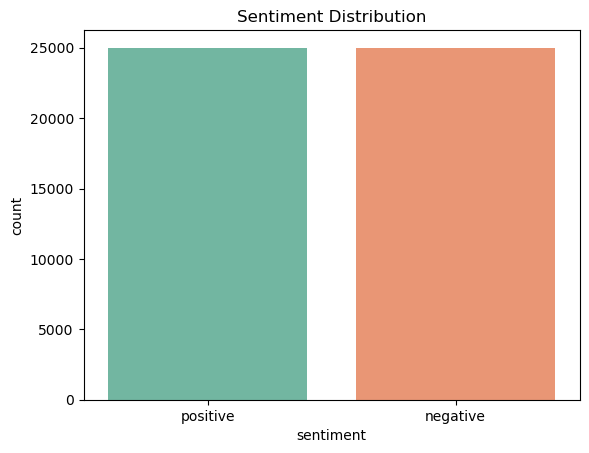

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [20]:
# Check Sentiment Distribution
sns.countplot(x='sentiment', data=df, palette='Set2', hue='sentiment', legend=False)
plt.title('Sentiment Distribution')
plt.show()

print(df['sentiment'].value_counts())

## 2. Cleaning & Preporcess the Data

### Cleaning Data

In [21]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load & Convert contractions dictionary to a more usable format
contraction_df = pd.read_csv('dataset/IMDB/contractions.csv')
# contraction_df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/contractions.csv')
contractions_map = dict(zip(contraction_df['Contraction'].str.lower(), contraction_df['Meaning'].str.lower()))

In [22]:
# Define a function for text cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis
    # Remove non-alphanumeric characters (keeping whitespace and commas for contraction replacement)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Replace contractions
    text_split = text.split()
    text_split = [contractions_map.get(word, word) for word in text_split]
    text = ' '.join(text_split)

    # Remove punctuation
    text = re.sub(r'[\.,!?;]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])

    return text

# Apply the cleaning function to the review column
df['processed_review'] = df['review'].apply(clean_text)

In [23]:
# Mapping 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [24]:
list(df['processed_review'][:5])

['one reviewer mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bi

In [25]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


### OPTIONAL (TRIM DATA TO 20k)

In [ ]:
df_trim = df.copy()

# Desired number of samples per class
samples_per_class = 10000

# Count the number of samples for each class
positive_count = (df_trim['sentiment'] == 1).sum()
negative_count = (df_trim['sentiment'] == 0).sum()

print("Number of positive samples:", positive_count)
print("Number of negative samples:", negative_count)

# Sample from each class if there are enough samples
if positive_count >= samples_per_class and negative_count >= samples_per_class:
    trimmed_positive = df_trim[df_trim['sentiment'] == 1].sample(samples_per_class, random_state=42)
    trimmed_negative = df_trim[df_trim['sentiment'] == 0].sample(samples_per_class, random_state=42)

    # Concatenate the two subsets
    df_lemmatization_trim = pd.concat([trimmed_positive, trimmed_negative])

    # Shuffle the dataset to mix positive and negative reviews
    df_lemmatization_trim = df_lemmatization_trim.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the trimmed dataset if needed
    # df_lemmatization_trim.to_csv('Trimmed_IMDB_Dataset.csv', index=False)

    print("Trimmed distribution:\n", df_trim['sentiment'].value_counts())
else:
    print("Not enough samples for each class to perform sampling.")


Number of positive samples: 25000
Number of negative samples: 25000
Trimmed distribution:
 sentiment
0    10000
1    10000
Name: count, dtype: int64


## 3. Some Visulization & Statistical Analysis


### Review Length Analysis
- The reviews have a wide range of lengths, from 32 to 13,704 characters.
- The average review length is about 1,309 characters, with a standard deviation of 989 caracters.
- The median length of reviews is 970 characters, indicating that half of the reviews are shorter than this and half are longer.

In [17]:
# # Calculate the length of each review (character count)
# df['review_length'] = df['review'].apply(len)

# # Calculate the length of reviews for each sentiment (word count)
# df['word_length'] = df['review'].apply(lambda x: len(x.split()))

# # Descriptive statistics for review lengths
# review_length_stats = df['review_length'].describe()
# review_length_stats

### Bar Plot 20 Most Common Words

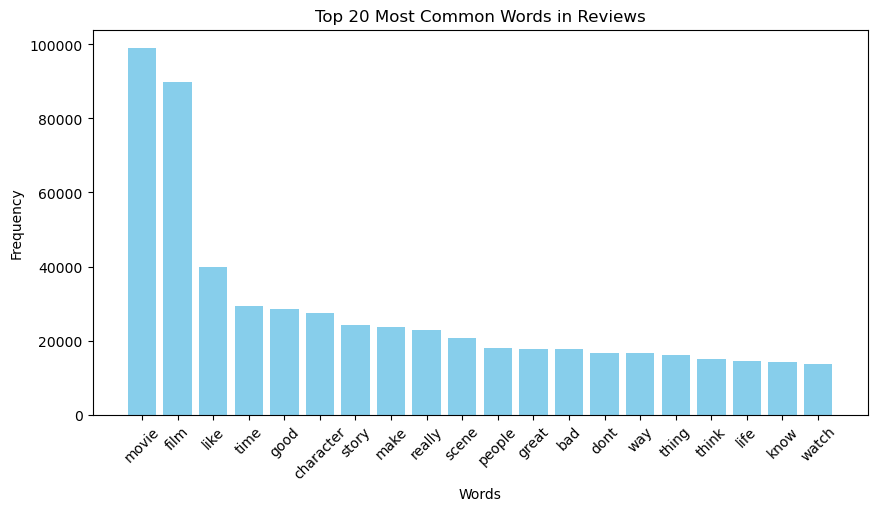

In [26]:
# Create a CountVectorizer to count word frequencies, limiting to the top 20 words
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# Fit and transform the data
word_counts = vectorizer.fit_transform(df['processed_review'])

# Sum up the counts of each vocabulary word
sum_words = word_counts.sum(axis=0)

# Connecting words with their counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Prepare data for plotting
words, counts = zip(*words_freq)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45)
plt.show()


### Word Cloud of Most common words in Positive and Negative Review

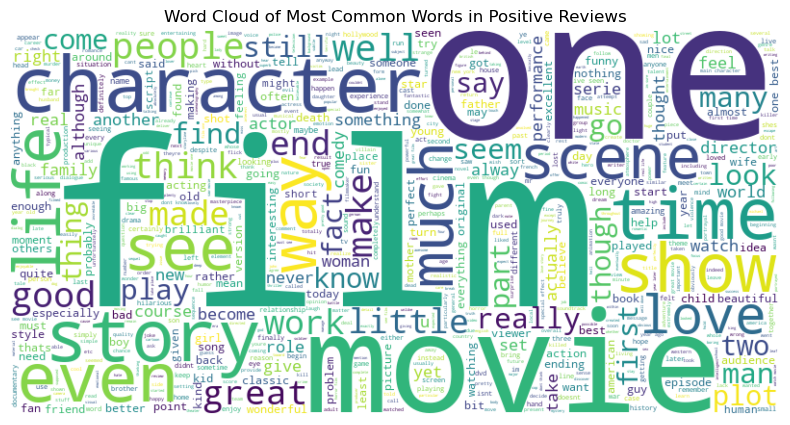

In [27]:
# Generate Word cloud for positive reviews
positive_reviews = df[df['sentiment'] == 1]
positive_text = list(positive_reviews['processed_review'])
positive_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(positive_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Positive Reviews')
plt.show()

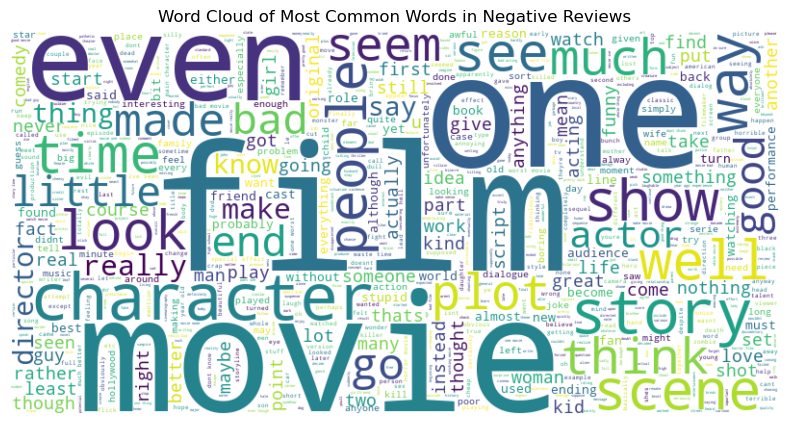

In [28]:
# Generate Word cloud for negative reviews
negative_reviews = df[df['sentiment'] == 0]
negative_text = list(negative_reviews['processed_review'])
negative_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(negative_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Negative Reviews')
plt.show()

## Model

In [ ]:
# Prepare feature matrix X and target vector y
X = df['processed_review']
y = df['sentiment']

In [ ]:
# WORD2VEC
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = [row.split() for row in df['processed_review']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# TF-IDF
# Vectorization of the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(X)

# WORD2VEC
# Convert word vectors to document vectors
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    
    return feature_vector

X_word2vec = np.array([
    average_word_vectors(words, word2vec_model, word2vec_model.wv.key_to_index, 100)
    for words in sentences
])

scaler = MinMaxScaler()
X_word2vec_normalized = scaler.fit_transform(X_word2vec)

# Combine TF-IDF and normalized Word2Vec features
X_combined = np.hstack((X.toarray(), X_word2vec_normalized))

### Logistic Regression

#### TF-IDF

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_tfidf_model = LogisticRegression()
logreg_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_tfidf_predictions = logreg_tfidf_model.predict(X_test)
logreg_tfidf_accuracy = accuracy_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_precision = precision_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_recall = recall_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_f1 = f1_score(y_test, logreg_tfidf_predictions)

In [ ]:
# Print the evaluation metrics
print('Using Lemmatization')
print("Accuracy:", logreg_tfidf_accuracy)
print("Precision:", logreg_tfidf_precision)
print("Recall:", logreg_tfidf_recall)
print("F1 Score:", logreg_tfidf_f1)

In [42]:
print(classification_report(y_test, logreg_tfidf_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



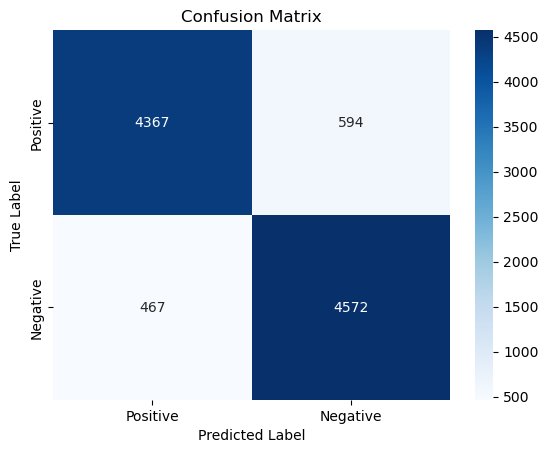

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, logreg_tfidf_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With TF-IDF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Word2Vec

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
logreg_w2v_model = LogisticRegression()
logreg_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_w2v_predictions = logreg_w2v_model.predict(X_test)
logreg_w2v_accuracy = accuracy_score(y_test, logreg_w2v_predictions)
logreg_w2v_precision = precision_score(y_test, logreg_w2v_predictions)
logreg_w2v_recall = recall_score(y_test, logreg_w2v_predictions)
logreg_w2v_f1 = f1_score(y_test, logreg_w2v_predictions)

In [ ]:
print('Logreg with Word2Vec')
print("Accuracy:", logreg_w2v_accuracy)
print("Precision:", logreg_w2v_precision)
print("Recall:", logreg_w2v_recall)
print("F1 Score:", logreg_w2v_f1)

NB with Word2Vec
Accuracy: 0.7264
Precision: 0.727075527509367
Recall: 0.7316927961897202
F1 Score: 0.7293768545994065


In [ ]:
print(classification_report(y_test, logreg_w2v_predictions))

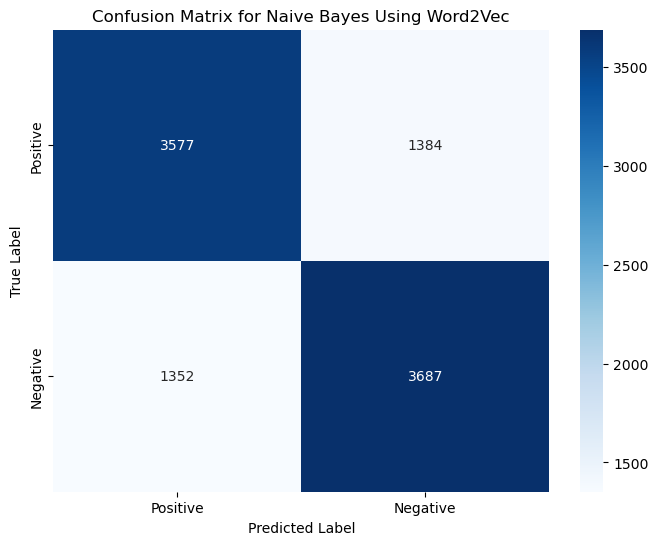

In [ ]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, logreg_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### TF-IDF & Word2Vec Combined

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
logreg_combined_model = LogisticRegression()
logreg_combined_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_combined_predictions = logreg_combined_model.predict(X_test)
logreg_combined_accuracy = accuracy_score(y_test, logreg_combined_predictions)
logreg_combined_precision = precision_score(y_test, logreg_combined_predictions)
logreg_combined_recall = recall_score(y_test, logreg_combined_predictions)
logreg_combined_f1 = f1_score(y_test, logreg_combined_predictions)

In [ ]:
print('Logreg with TF-IDF and Word2Vec')
print("Accuracy:", logreg_combined_accuracy)
print("Precision:", logreg_combined_precision)
print("Recall:", logreg_combined_recall)
print("F1 Score:", logreg_combined_f1)

In [ ]:
print(classification_report(y_test, logreg_combined_predictions))

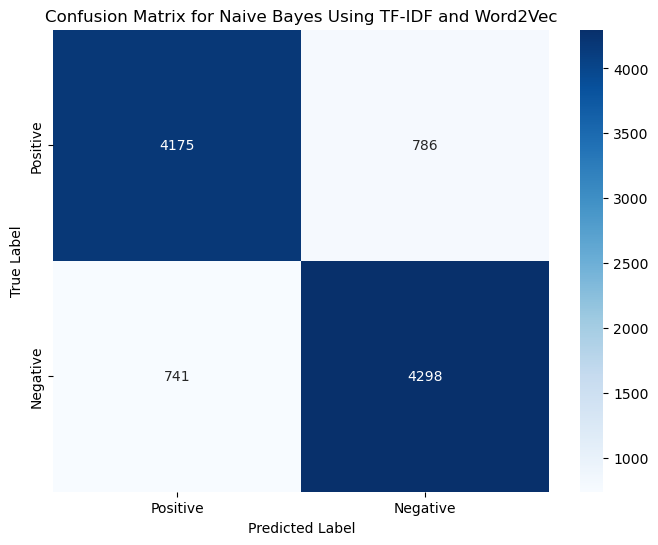

In [ ]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, logreg_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### SVM

#### TF-IDF

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_tfidf_model = SVC(kernel='linear')
svm_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
svm_tfidf_predictions = svm_tfidf_model.predict(X_test)
svm_tfidf_accuracy = accuracy_score(y_test, svm_tfidf_predictions)
svm_tfidf_precision = precision_score(y_test, svm_tfidf_predictions)
svm_tfidf_recall = recall_score(y_test, svm_tfidf_predictions)
svm_tfidf_f1 = f1_score(y_test, svm_tfidf_predictions)

In [53]:
# Print the evaluation metrics
print('SVM Evaluation')
print("Accuracy:", svm_tfidf_accuracy)
print("Precision:", svm_tfidf_precision)
print("Recall:", svm_tfidf_recall)
print("F1 Score:", svm_tfidf_f1)

SVM Evaluation
Accuracy: 0.8972
Precision: 0.8917757374487204
Recall: 0.9059337170073427
F1 Score: 0.8987989761764127


In [54]:
print(classification_report(y_test, svm_tfidf_predictions))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



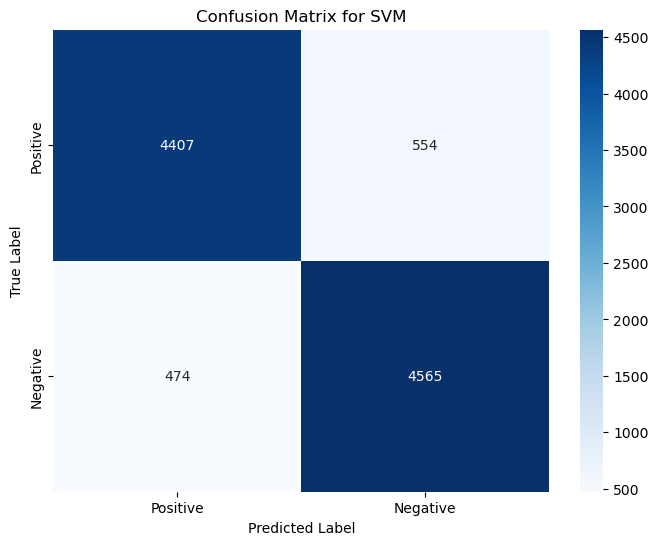

In [55]:
# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_test, svm_tfidf_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with TF-IDF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Word2Vec

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
svm_w2v_model = SVC(kernel='linear')
svm_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
svm_w2v_predictions = svm_w2v_model.predict(X_test)
svm_w2v_accuracy = accuracy_score(y_test, svm_w2v_predictions)
svm_w2v_precision = precision_score(y_test, svm_w2v_predictions)
svm_w2v_recall = recall_score(y_test, svm_w2v_predictions)
svm_w2v_f1 = f1_score(y_test, svm_w2v_predictions)

In [ ]:
print('SVM with Word2Vec')
print("Accuracy:", svm_w2v_accuracy)
print("Precision:", svm_w2v_precision)
print("Recall:", svm_w2v_recall)
print("F1 Score:", svm_w2v_f1)


NB with Word2Vec
Accuracy: 0.7264
Precision: 0.727075527509367
Recall: 0.7316927961897202
F1 Score: 0.7293768545994065


In [ ]:
print(classification_report(y_test, svm_w2v_predictions))

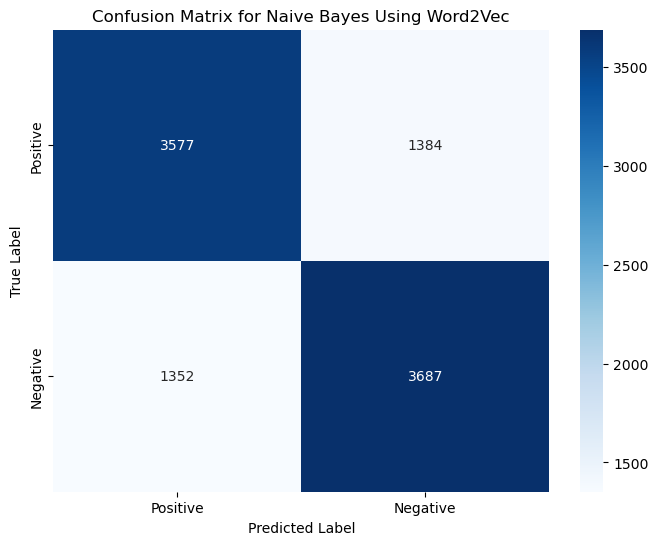

In [ ]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, svm_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with Word2vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Using Lemmatization with TF-IDF & Word2Vec Combined

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
svm_combined_model = SVC(kernel='linear')
svm_combined_model.fit(X_train, y_train)

# Predictions and evaluation
svm_combined_predictions = svm_combined_model.predict(X_test)
svm_combined_accuracy = accuracy_score(y_test, svm_combined_predictions)
svm_combined_precision = precision_score(y_test, svm_combined_predictions)
svm_combined_recall = recall_score(y_test, svm_combined_predictions)
svm_combined_f1 = f1_score(y_test, svm_combined_predictions)

In [ ]:
print('SVM with TF-IDF and Word2Vec')
print("Accuracy:", svm_combined_accuracy)
print("Precision:", svm_combined_precision)
print("Recall:", svm_combined_recall)
print("F1 Score:", svm_combined_f1)

In [ ]:
print(classification_report(y_test, svm_combined_predictions))

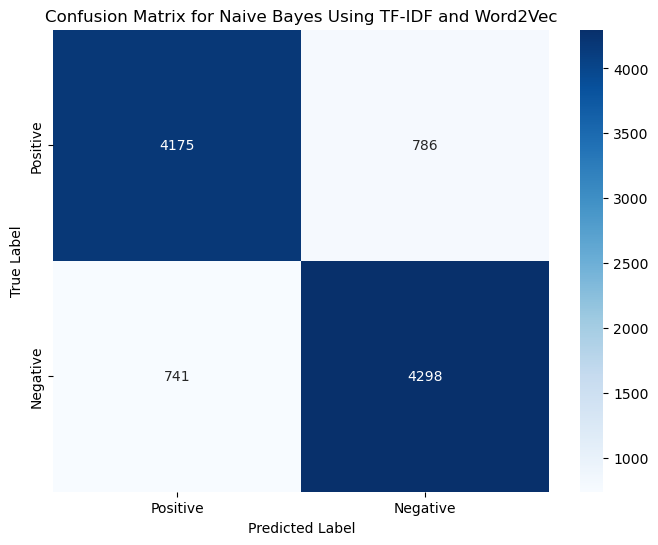

In [ ]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, svm_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Naive Bayes

#### TF=IDF

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
nb_tfidf_predictions = nb_tfidf_model.predict(X_test)
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predictions)
nb_tfidf_precision = precision_score(y_test, nb_tfidf_predictions)
nb_tfidf_recall = recall_score(y_test, nb_tfidf_predictions)
nb_tfidf_f1 = f1_score(y_test, nb_tfidf_predictions)

In [65]:
# Print the evaluation metrics
print('NB with TF-IDF')
print("Accuracy:", nb_tfidf_accuracy)
print("Precision:", nb_tfidf_precision)
print("Recall:", nb_tfidf_recall)
print("F1 Score:", nb_tfidf_f1)

NB with Lemmatization Evaluation
Accuracy: 0.8663
Precision: 0.878992628992629
Recall: 0.851954752927168
F1 Score: 0.8652625214148947


In [66]:
print( classification_report(y_test, nb_tfidf_predictions))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



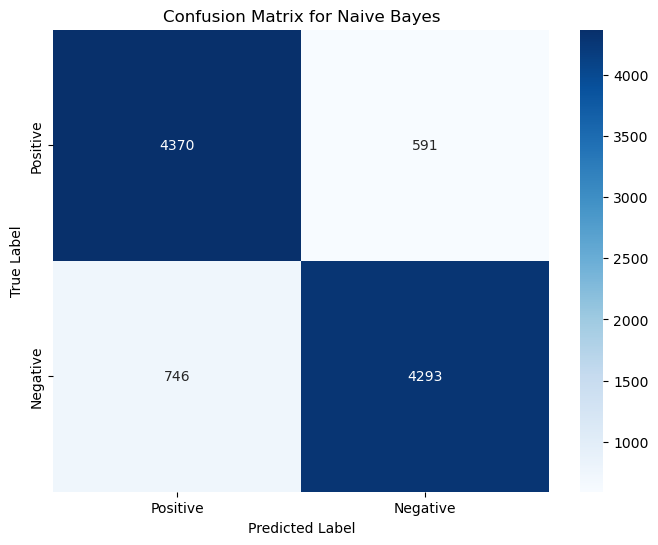

In [67]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_tfidf_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with TF-IDF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Word2Vec

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
nb_w2v_model = MultinomialNB()
nb_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
nb_w2v_predictions = nb_w2v_model.predict(X_test)
nb_w2v_accuracy = accuracy_score(y_test, nb_w2v_predictions)
nb_w2v_precision = precision_score(y_test, nb_w2v_predictions)
nb_w2v_recall = recall_score(y_test, nb_w2v_predictions)
nb_w2v_f1 = f1_score(y_test, nb_w2v_predictions)


In [49]:
print('NB with Word2Vec')
print("Accuracy:", nb_w2v_accuracy)
print("Precision:", nb_w2v_precision)
print("Recall:", nb_w2v_recall)
print("F1 Score:", nb_w2v_f1)


NB with Word2Vec
Accuracy: 0.7264
Precision: 0.727075527509367
Recall: 0.7316927961897202
F1 Score: 0.7293768545994065


In [ ]:
print( classification_report(y_test, nb_w2v_predictions))

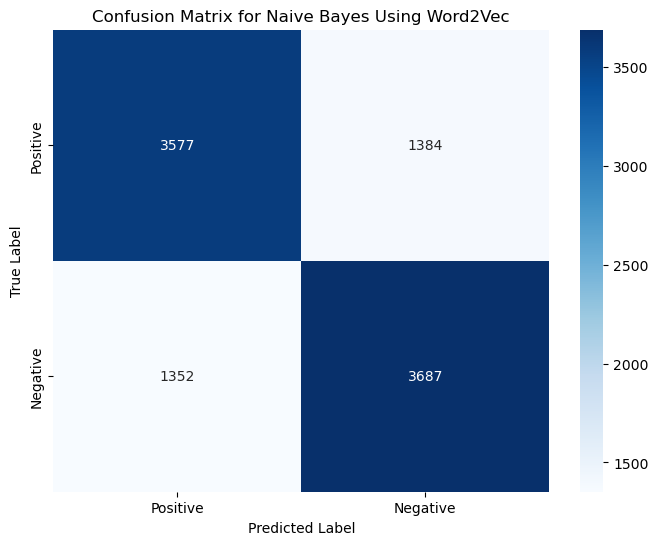

In [51]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### TF-IDF & Word2Vec Combined

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
nb_combined_model = MultinomialNB()
nb_combined_model.fit(X_train, y_train)

# Predictions and evaluation
nb_combined_predictions = nb_combined_model.predict(X_test)
nb_combined_accuracy = accuracy_score(y_test, nb_combined_predictions)
nb_combined_precision = precision_score(y_test, nb_combined_predictions)
nb_combined_recall = recall_score(y_test, nb_combined_predictions)
nb_combined_f1 = f1_score(y_test, nb_combined_predictions)

In [ ]:
print('NB with TF-IDF and Word2Vec')
print("Accuracy:", nb_combined_accuracy)
print("Precision:", nb_combined_precision)
print("Recall:", nb_combined_recall)
print("F1 Score:", nb_combined_f1)

In [ ]:
print( classification_report(y_test, nb_combined_predictions))

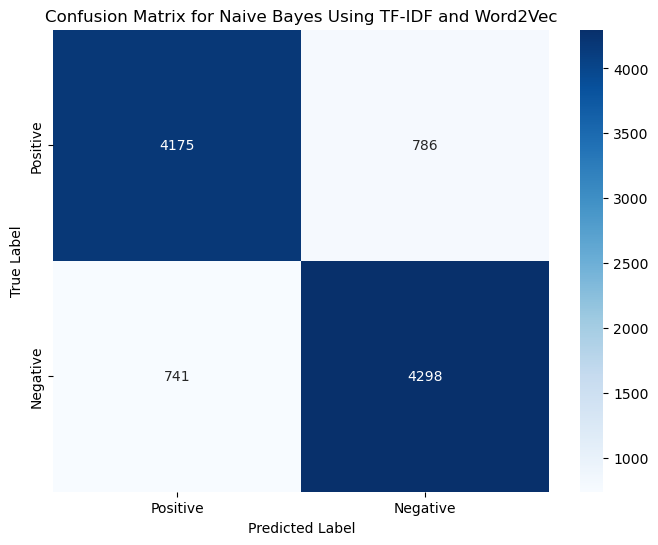

In [ ]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### BILSTM

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

import time
import json

#### Utils

In [41]:
# Training function at each epoch
def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader.dataset)

def predicting(model, device, loader, loss_fn):
    test_outputs_list = []
    test_labels_list = []
    model.eval()
    total_loss = 0
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    with torch.no_grad():
        for embeddings, labels in loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            total_loss_test = total_loss / len(loader.dataset)
            
            predicted = (outputs > 0.5).float()
            test_outputs_list.append(predicted)
            test_labels_list.append(labels)
        
    return total_loss_test, test_outputs_list, test_labels_list

In [42]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2vec):
        self.reviews = reviews
        self.labels = labels
        self.word2vec = word2vec

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Convert words to their corresponding embeddings
        words = self.reviews[idx]
        embeddings = [self.word2vec.wv[word] for word in words if word in self.word2vec.wv]

        # Convert list of numpy arrays to a single numpy array before converting to tensor
        embeddings = np.array(embeddings, dtype=np.float32)

        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return embeddings, label

def collate_fn(batch):
    # Sort the batch in the descending order of sequence length
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, labels = zip(*batch)
    # Pad the sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels

#### MODEL

In [43]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5) # Dropout layer

    def forward(self, x):
        # Computing the packed sequence of embeddings
        packed_output, (hidden, cell) = self.lstm(x)
        # Concatenate the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped = self.dropout(hidden)
        out = self.fc(dropped)
        return torch.sigmoid(out)

#### WORD2VEC

In [45]:
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = [row.split() for row in df_lemmatization['processed_review']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [44]:
# Save the model for later use
# word2vec_model.save("/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/word2vec_imdb.model")
word2vec_model.save("model/word2vec_imdb.model")

#### Model Init

In [60]:
# Define CUDA device name
cuda_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(cuda_name)
print('device:', device)

# Define other training parameters
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LR = 0.0001
NUM_EPOCHS = 100

# Hyperparameters
embedding_dim = 100  # As per Word2Vec setting
hidden_dim = 128
output_dim = 1
num_layers = 2

# Initialize model, loss, and optimizer
model = BiLSTM(embedding_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
loss_fn = nn.BCELoss()

# Early Stopping Setup
early_stopping_patience = 5
early_stopping_counter = 0
min_val_loss = float('inf')

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

device: cuda:0


#### SPLIT DATASET

In [47]:
# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(sentences, df_lemmatization['sentiment'].values, test_size=0.2, random_state=42, stratify=df_lemmatization['sentiment'].values)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# Create Datasets
train_dataset = IMDBDataset(train_data, train_labels, word2vec_model)
val_dataset = IMDBDataset(val_data, val_labels, word2vec_model)
test_dataset = IMDBDataset(test_data, test_labels, word2vec_model)

print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

Training set size: 40000 samples
Validation set size: 5000 samples
Test set size: 5000 samples


#### Data Loader

In [48]:
# Data preparation and loaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False,  collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,  collate_fn=collate_fn)
print("Data loaders initialized.")

Data loaders initialized.


#### Training

In [61]:
writer = SummaryWriter('tensorboard/bilstm_50k-new')

# store metrics
train_losses, val_losses, eval_metrics = [], [], []

print('cuda_name:', cuda_name)
print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)
print('Running on: ', BiLSTM.__name__)
print('\n')

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    print(f'Epoch {epoch}:')

    print('Training on {} samples...'.format(len(train_loader.dataset)))
    train_loss = train(model, device, train_loader, optimizer, loss_fn)
    train_losses.append(train_loss)
    writer.add_scalar('Training Loss', train_loss, epoch)
    print(f'Training Loss: {train_loss:.4f}')

    print('Validation on for {} samples...'.format(len(val_loader.dataset)))
    val_loss, labels, preds = predicting(model, device, val_loader, loss_fn)
    val_losses.append(val_loss)
    writer.add_scalar('Validation Loss', val_loss, epoch)
    print(f'Validation Loss: {val_loss:.4f}')

    writer.flush()

    # Evaluation metrics
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    precision = precision_score(labels.cpu(), preds.cpu())
    recall = recall_score(labels.cpu(), preds.cpu())
    f1 = f1_score(labels.cpu(), preds.cpu())

    eval_metrics.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    end_time = time.time()
    duration_seconds = int(end_time - start_time)
    hours = duration_seconds // 3600
    minutes = (duration_seconds % 3600) // 60
    seconds = duration_seconds % 60

    # print('Validation Evaluation Metrics')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    # print(f'Training Duration: {(end_time - start_time):.2f}s\n')

    # Early Stopping Check
    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stopping_counter = 0
    # else:
    #     early_stopping_counter += 1
    #     if early_stopping_counter >= early_stopping_patience:
    #         print("Early stopping triggered.")
    #         break

    # Adjust learning rate based on validation loss
    # print('Adjusting learning rate based on validation loss...')
    # scheduler.step(val_loss)
    # last_lr = scheduler.get_last_lr()
    # current_lr = optimizer.param_groups[0]['lr']
    # print(f'Last LR: {last_lr} | Current LR: {current_lr}')
    
    print(f'Training Duration: {hours}h:{minutes}m:{seconds}s\n')

writer.close()

cuda_name: cuda:0
Learning rate:  0.0001
Epochs:  100
Running on:  BiLSTM


Epoch 1:
Training on 40000 samples...
Training Loss: 0.0149
Validation on for 5000 samples...
Validation Loss: 0.0123
Accuracy: 0.8358, Precision: 0.7588, Recall: 0.8969, F1: 0.8221
Training Duration: 0h:2m:37s

Epoch 2:
Training on 40000 samples...
Training Loss: 0.0127
Validation on for 5000 samples...
Validation Loss: 0.0116
Accuracy: 0.8600, Precision: 0.9104, Recall: 0.8270, F1: 0.8667
Training Duration: 0h:2m:51s

Epoch 3:
Training on 40000 samples...
Training Loss: 0.0116
Validation on for 5000 samples...
Validation Loss: 0.0110
Accuracy: 0.8474, Precision: 0.9308, Recall: 0.7977, F1: 0.8591
Training Duration: 0h:3m:0s

Epoch 4:
Training on 40000 samples...
Training Loss: 0.0102
Validation on for 5000 samples...
Validation Loss: 0.0093
Accuracy: 0.8806, Precision: 0.8724, Recall: 0.8869, F1: 0.8796
Training Duration: 0h:3m:2s

Epoch 5:
Training on 40000 samples...
Training Loss: 0.0103
Validation on for 

##### Saved Model & Metrics

In [62]:
torch.save(model.state_dict(), 'model/bilstm_50k_new.pth')

In [63]:
import pickle
# Define the file path to save the data
file_path = 'metrics/bilstm_50k_new.pkl'

# Create a dictionary to store the data
data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'eval_metrics': eval_metrics
}

# Save the data to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(data, f)

print('Metrics saved successfully.')


Metrics saved successfully.


##### Load Models & Metrics

In [64]:
model.load_state_dict(torch.load('model/bilstm_50k_new.pth'))

<All keys matched successfully>

In [65]:
import pickle
file_path = 'metrics/bilstm_50k_new.pkl'

with open(file_path, 'rb') as f:
    metrics = pickle.load(f)

In [66]:
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
eval_metrics = metrics['eval_metrics']

##### Evaluating

In [67]:
print('Testing on for {} samples...'.format(len(test_loader.dataset)))
test_loss, labels, preds = predicting(model, device, test_loader, loss_fn)
print(f'Testing Loss: {test_loss:.4f}')

preds = torch.cat(preds)
labels = torch.cat(labels)
bilstm_accuracy = accuracy_score(labels.cpu(), preds.cpu())
bilstm_precision = precision_score(labels.cpu(), preds.cpu())
bilstm_recall = recall_score(labels.cpu(), preds.cpu())
bilstm_f1 = f1_score(labels.cpu(), preds.cpu())

print('Testing Evaluation Metrics')
# print(f'MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, Pearson: {pearson_test:.4f}, Spearman: {spearman_test:.4f}, CI: {ci_test:.4f}, R2m: {r2m_test:.4f}')
print(f'Accuracy: {bilstm_accuracy:.4f}, Precision: {bilstm_precision:.4f}, Recall: {bilstm_recall:.4f}, F1: {bilstm_f1:.4f}')

Testing on for 5000 samples...
Testing Loss: 0.0184
Testing Evaluation Metrics
Accuracy: 0.8818, Precision: 0.8760, Recall: 0.8863, F1: 0.8811


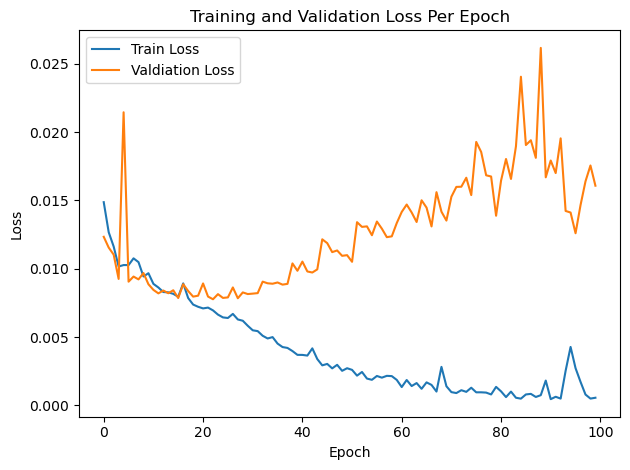

In [68]:
# Extract metrics
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
# train_accuracies = metrics['train_accuracy']
# test_accuracies = metrics['test_accuracy']

# Plotting training and testing losses
# plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

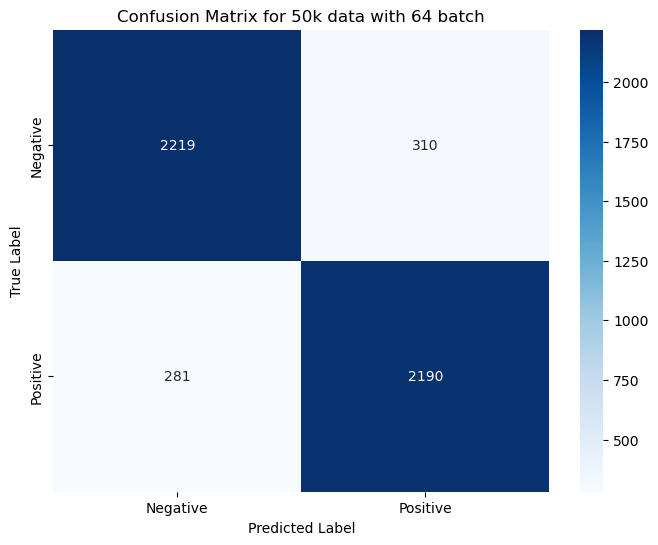

In [69]:
cm = confusion_matrix(labels.cpu(), preds.cpu())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for 50k data with 64 batch')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Metrics Model Comparison

## Feature Extraction Comparison

### Logistic Regression

In [ ]:
# plot logistic regression with tf-idf, word2vec, combined

# Plotting the evaluation metrics
# Create a dictionary to store the data
data = {
    'accuracy': [logreg_tfidf_accuracy, logreg_w2v_accuracy, logreg_combined_accuracy],
    'precision': [logreg_tfidf_precision, logreg_w2v_precision, logreg_combined_precision],
    'recall': [logreg_tfidf_recall, logreg_w2v_recall, logreg_combined_recall],
    'f1': [logreg_tfidf_f1, logreg_w2v_f1, logreg_combined_f1]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data, index=['TF-IDF', 'Word2Vec', 'Combined'])

# Plot the evaluation metrics
df.plot(kind='bar', figsize=(10, 6))
plt.title('Logistic Regression Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [32]:
data = {
    'accuracy': [logreg_tfidf_accuracy, logreg_w2v_accuracy, logreg_combined_accuracy],
    'precision': [logreg_tfidf_precision, logreg_w2v_precision, logreg_combined_precision],
    'recall': [logreg_tfidf_recall, logreg_w2v_recall, logreg_combined_recall],
    'f1': [logreg_tfidf_f1, logreg_w2v_f1, logreg_combined_f1]
}

# compare accuracy
import matplotlib.pyplot as plt

# Extract the accuracy values from the data dictionary
accuracy_values = data['accuracy']

# Create a list of model names
model_names = ['LogReg TF-IDF', 'LogReg W2V', 'LogReg Combined']

# Plot the accuracy values
plt.bar(model_names, accuracy_values)
for i in range(3):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.show()

NameError: name 'logreg_tfidf_accuracy' is not defined

### SVM

### Naive Bayes

## Model Comparison

In [129]:
print('Logistic Regression TF-I')
print("Accuracy:", logreg_lemma_accuracy)
print("Precision:", logreg_lemma_precision)
print("Recall:", logreg_lemma_recall)
print("F1 Score:", logreg_lemma_f1)
print("")

print('SVM')
print("Accuracy:", svm_lemma_accuracy)
print("Precision:", svm_lemma_precision)
print("Recall:", svm_lemma_recall)
print("F1 Score:", svm_lemma_f1)
print("")

print('Naive Bayes')
print("Accuracy:", nb_lemma_accuracy)
print("Precision:", nb_lemma_precision)
print("Recall:", nb_lemma_recall)
print("F1 Score:", nb_lemma_f1)
print("")

print('BiLSTM')
print(f'Accuracy: {bilstm_accuracy:.4f}, Precision: {bilstm_precision:.4f}, Recall: {bilstm_recall:.4f}, F1: {bilstm_f1:.4f}')

Logistic Regression
Accuracy: 0.8939
Precision: 0.8850174216027874
Recall: 0.9073228815241119
F1 Score: 0.896031357177854

SVM
Accuracy: 0.8972
Precision: 0.8917757374487204
Recall: 0.9059337170073427
F1 Score: 0.8987989761764127

Naive Bayes
Accuracy: 0.8663
Precision: 0.878992628992629
Recall: 0.851954752927168
F1 Score: 0.8652625214148947

BiLSTM
Accuracy: 0.8928, Precision: 0.9036, Recall: 0.8845, F1: 0.8939


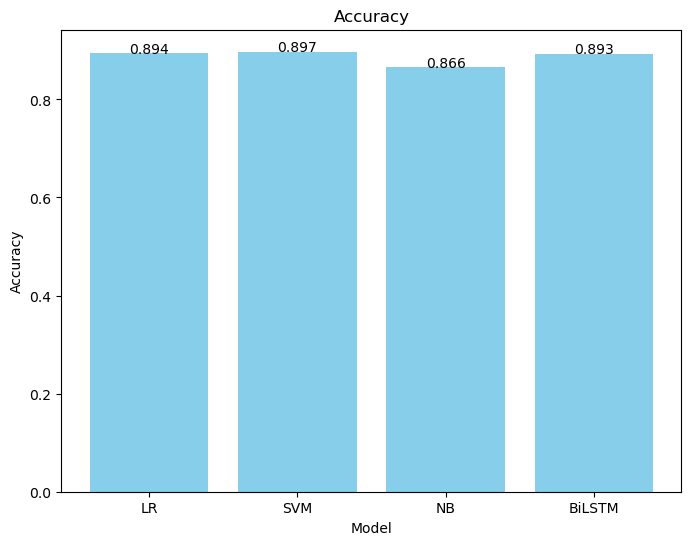

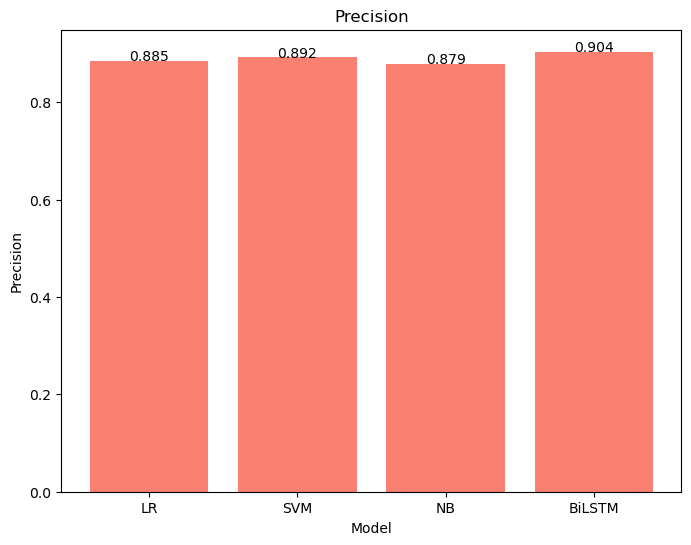

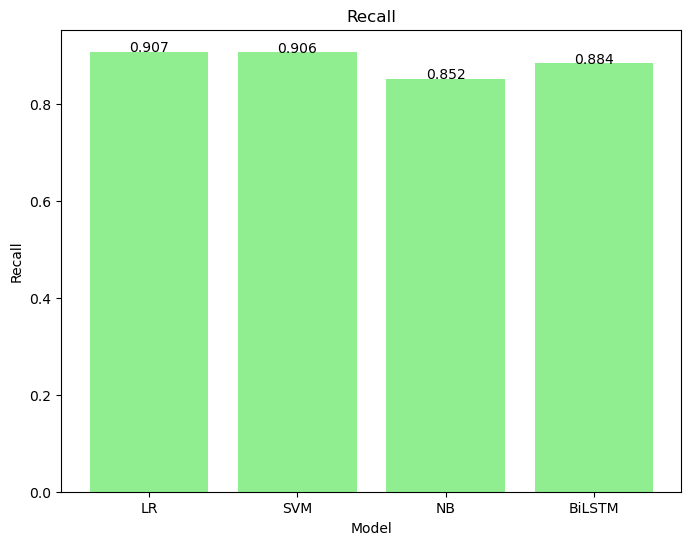

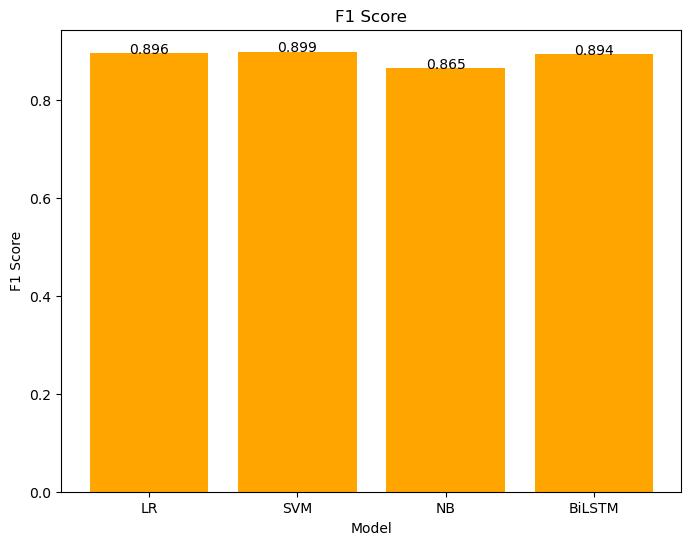

In [130]:
# plot all accuracy, precision, recall, f1 in bar

# Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [logreg_lemma_accuracy, svm_lemma_accuracy, nb_lemma_accuracy, bilstm_accuracy], color='skyblue')
for i in range(4):
    plt.text(i, round([logreg_lemma_accuracy, svm_lemma_accuracy, nb_lemma_accuracy, bilstm_accuracy][i], 3), round([logreg_lemma_accuracy, svm_lemma_accuracy, nb_lemma_accuracy, bilstm_accuracy][i], 3), ha = 'center')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Precision
plt.figure(figsize=(8, 6))
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [logreg_lemma_precision, svm_lemma_precision, nb_lemma_precision, bilstm_precision], color='salmon')
for i in range(4):
    plt.text(i, round([logreg_lemma_precision, svm_lemma_precision, nb_lemma_precision, bilstm_precision][i], 3), round([logreg_lemma_precision, svm_lemma_precision, nb_lemma_precision, bilstm_precision][i], 3), ha = 'center')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

# Recall
plt.figure(figsize=(8, 6))
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [logreg_lemma_recall, svm_lemma_recall, nb_lemma_recall, bilstm_recall], color='lightgreen')
for i in range(4):
    plt.text(i, round([logreg_lemma_recall, svm_lemma_recall, nb_lemma_recall, bilstm_recall][i], 3), round([logreg_lemma_recall, svm_lemma_recall, nb_lemma_recall, bilstm_recall][i], 3), ha = 'center')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Recall')

# F1 Score
plt.figure(figsize=(8, 6))
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [logreg_lemma_f1, svm_lemma_f1, nb_lemma_f1, bilstm_f1], color='orange')
for i in range(4):
    plt.text(i, round([logreg_lemma_f1, svm_lemma_f1, nb_lemma_f1, bilstm_f1][i], 3), round([logreg_lemma_f1, svm_lemma_f1, nb_lemma_f1, bilstm_f1][i], 3), ha = 'center')
plt.title('F1 Score')  
plt.xlabel('Model')
plt.ylabel('F1 Score')

# plt.tight_layout()
plt.show()